# RNN Basic Implementation

In [64]:
import numpy as np

def relu(x):
  return np.maximum(0, x)

In [65]:
# Input to Hidden
W_xh = np.array([[1],[0],[0]])

# Hidden to Hidden
W_hh = np.array([
    [0,0,0],
    [1,0,0],
    [0,0,1]
])

# Hidden to Output
W_hy = np.array([1,1,-1])

# Initial hidden state
h_t_prev = np.array([[0],[0], [1]])

# Input sequence
x_seq = [0,1,0,1,1,1,0,1,1]


In [66]:
for t,x in enumerate(x_seq):

    # New hidden state
    h_t = relu( W_hh @ h_t_prev + W_xh @ [[x]] )

    # Output
    y_t = relu(W_hy @ h_t)
    print(f"Time step {t}-x:{x} y:{y_t}, \n {h_t}")
    # Update hidden state for next time step
    h_t_prev = h_t

Time step 0-x:0 y:[0], 
 [[0]
 [0]
 [1]]
Time step 1-x:1 y:[0], 
 [[1]
 [0]
 [1]]
Time step 2-x:0 y:[0], 
 [[0]
 [1]
 [1]]
Time step 3-x:1 y:[0], 
 [[1]
 [0]
 [1]]
Time step 4-x:1 y:[1], 
 [[1]
 [1]
 [1]]
Time step 5-x:1 y:[1], 
 [[1]
 [1]
 [1]]
Time step 6-x:0 y:[0], 
 [[0]
 [1]
 [1]]
Time step 7-x:1 y:[0], 
 [[1]
 [0]
 [1]]
Time step 8-x:1 y:[1], 
 [[1]
 [1]
 [1]]


In [67]:
"""
==============================================================================
VANILLA RNN — From Scratch in NumPy
==============================================================================

Architecture:
                    y_t
                     ↑
                  [W_hy]
                     ↑
   h_{t-1} --→ [  h_t  ] --→ h_t  (passed to next step)
                  ↑    ↑
              [W_hh] [W_xh]
                ↑      ↑
           h_{t-1}    x_t

Core equations (forward pass):
    h_t = activation( W_xh · x_t  +  W_hh · h_{t-1}  +  b_h )
    y_t = softmax(    W_hy · h_t  +  b_y )

Core equations (backward pass — BPTT):
    dL/dW = sum over time of gradients flowing back through the unrolled graph
"""

import numpy as np

np.random.seed(42)


# =============================================================================
# 1. ACTIVATION FUNCTIONS
# =============================================================================

def tanh(x):
    """
    Tanh squashes values to [-1, 1].
    Preferred over sigmoid in hidden states because it's zero-centered,
    which helps gradient flow.
    """
    return np.tanh(x)


def tanh_derivative(x):
    """d/dx tanh(x) = 1 - tanh²(x)"""
    return 1.0 - np.tanh(x) ** 2


def softmax(x):
    """
    Converts raw scores (logits) into probabilities that sum to 1.
    Subtract max for numerical stability (avoids overflow in exp).
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


# =============================================================================
# 2. THE VANILLA RNN CLASS
# =============================================================================

class VanillaRNN:
    """
    A character-level RNN that learns to predict the next character.

    Parameters
    ----------
    input_size  : int — number of unique input tokens (vocabulary size)
    hidden_size : int — number of hidden units (the "memory" capacity)
    output_size : int — number of unique output tokens (often = input_size)
    lr          : float — learning rate

    Weight matrices
    ---------------
    W_xh : (hidden_size, input_size)  — input  → hidden
    W_hh : (hidden_size, hidden_size) — hidden → hidden (recurrence!)
    W_hy : (output_size, hidden_size) — hidden → output
    b_h  : (hidden_size, 1)           — hidden bias
    b_y  : (output_size, 1)           — output bias
    """

    def __init__(self, input_size, hidden_size, output_size, lr=0.01):
        self.hidden_size = hidden_size
        self.lr = lr

        # --- Weight initialization (Xavier / sqrt scale) ---
        scale = lambda fan_in: 1.0 / np.sqrt(fan_in)

        self.W_xh = np.random.randn(hidden_size, input_size)  * scale(input_size)
        self.W_hh = np.random.randn(hidden_size, hidden_size) * scale(hidden_size)
        self.W_hy = np.random.randn(output_size, hidden_size) * scale(hidden_size)
        self.b_h  = np.zeros((hidden_size, 1))
        self.b_y  = np.zeros((output_size, 1))

        # --- Adagrad memory (for adaptive learning rate) ---
        self.mW_xh = np.zeros_like(self.W_xh)
        self.mW_hh = np.zeros_like(self.W_hh)
        self.mW_hy = np.zeros_like(self.W_hy)
        self.mb_h  = np.zeros_like(self.b_h)
        self.mb_y  = np.zeros_like(self.b_y)

    # -----------------------------------------------------------------
    # 2a. FORWARD PASS  (one full sequence)
    # -----------------------------------------------------------------
    def forward(self, inputs, targets, h_prev):
        """
        Run the RNN forward through the sequence and compute loss.

        Parameters
        ----------
        inputs  : list of int — input token indices  [x_0, x_1, ..., x_{T-1}]
        targets : list of int — target token indices  [x_1, x_2, ..., x_T]
        h_prev  : (hidden_size, 1) — initial hidden state

        Returns
        -------
        loss       : scalar — cross-entropy loss over the sequence
        cache      : dict   — everything needed for backward pass

        Step-by-step for each time step t:
        ┌─────────────────────────────────────────────────┐
        │  1. One-hot encode x_t                          │
        │  2. Compute raw hidden: z_t = W_xh·x_t          │
        │                              + W_hh·h_{t-1}     │
        │                              + b_h               │
        │  3. Apply activation:  h_t = tanh(z_t)          │
        │  4. Compute output:    o_t = W_hy·h_t + b_y     │
        │  5. Compute probs:     p_t = softmax(o_t)       │
        │  6. Accumulate loss:   L -= log(p_t[target_t])   │
        └─────────────────────────────────────────────────┘
        """
        xs, hs, zs, os, ps = {}, {}, {}, {}, {}
        hs[-1] = np.copy(h_prev)  # h at t=-1 is the initial state
        loss = 0.0

        for t in range(len(inputs)):
            # --- One-hot encode input ---
            xs[t] = np.zeros((self.W_xh.shape[1], 1))
            xs[t][inputs[t]] = 1.0

            # --- Raw hidden state (pre-activation) ---
            #       ┌── from input ──┐  ┌── recurrence ──┐  ┌ bias ┐
            zs[t] = self.W_xh @ xs[t] + self.W_hh @ hs[t-1] + self.b_h

            # --- Activated hidden state ---
            hs[t] = tanh(zs[t])

            # --- Output logits ---
            os[t] = self.W_hy @ hs[t] + self.b_y

            # --- Probabilities ---
            ps[t] = softmax(os[t])

            # --- Cross-entropy loss ---
            loss -= np.log(ps[t][targets[t], 0] + 1e-12)

        cache = {'xs': xs, 'hs': hs, 'zs': zs, 'ps': ps}
        return loss, cache

    # -----------------------------------------------------------------
    # 2b. BACKWARD PASS  (Backpropagation Through Time — BPTT)
    # -----------------------------------------------------------------
    def backward(self, inputs, targets, cache):
        """
        Compute gradients via BPTT.

        The key insight: since h_t depends on h_{t-1}, which depends on
        h_{t-2}, etc., gradients flow backward through ALL previous time
        steps. This is what makes RNNs powerful (and prone to vanishing
        gradients).

        Gradient flow diagram (backward):

        dL/dy_t → dL/do_t → dL/dh_t ─→ dL/dW_hy
                                │
                    ┌───────────┴───────────┐
                    ↓                       ↓
               dL/dz_t                 dL/dh_{t-1}  ← RECURRENT GRADIENT!
                 │  │                       │
                 ↓  ↓                       ↓
          dL/dW_xh  dL/dW_hh          (flows to t-1)
        """
        xs, hs, zs, ps = cache['xs'], cache['hs'], cache['zs'], cache['ps']

        # Initialize gradients
        dW_xh = np.zeros_like(self.W_xh)
        dW_hh = np.zeros_like(self.W_hh)
        dW_hy = np.zeros_like(self.W_hy)
        db_h  = np.zeros_like(self.b_h)
        db_y  = np.zeros_like(self.b_y)

        dh_next = np.zeros_like(hs[0])  # gradient flowing from future

        # Walk BACKWARD through time
        for t in reversed(range(len(inputs))):
            # --- Output gradient ---
            # For cross-entropy + softmax: dL/do_t = p_t - one_hot(target)
            do = np.copy(ps[t])
            do[targets[t]] -= 1.0  # This elegant formula is softmax + CE combined

            # --- Gradients for W_hy, b_y ---
            dW_hy += do @ hs[t].T    # (output_size, hidden_size)
            db_y  += do

            # --- Hidden state gradient ---
            # dL/dh_t comes from TWO sources:
            #   1. The output at time t:     W_hy^T · do
            #   2. The hidden state at t+1:  dh_next (from the FUTURE!)
            dh = self.W_hy.T @ do + dh_next

            # --- Through tanh activation ---
            # dL/dz_t = dL/dh_t * tanh'(z_t)
            dz = dh * tanh_derivative(zs[t])

            # --- Gradients for W_xh, W_hh, b_h ---
            dW_xh += dz @ xs[t].T     # input contribution
            dW_hh += dz @ hs[t-1].T   # recurrent contribution
            db_h  += dz

            # --- Pass gradient to previous time step ---
            # This is the RECURRENT gradient: dL/dh_{t-1} = W_hh^T · dz
            # ⚠️ If W_hh has small eigenvalues, this shrinks → VANISHING GRADIENT
            # ⚠️ If W_hh has large eigenvalues, this grows  → EXPLODING GRADIENT
            dh_next = self.W_hh.T @ dz

        # --- Gradient clipping (prevent exploding gradients) ---
        for grad in [dW_xh, dW_hh, dW_hy, db_h, db_y]:
            np.clip(grad, -5, 5, out=grad)

        return dW_xh, dW_hh, dW_hy, db_h, db_y

    # -----------------------------------------------------------------
    # 2c. PARAMETER UPDATE (Adagrad)
    # -----------------------------------------------------------------
    def update(self, grads):
        """
        Adagrad update: lr_effective = lr / sqrt(sum_of_squared_grads)

        This adaptively reduces the learning rate for frequently updated
        parameters, which is helpful for RNNs where some characters
        appear much more often than others.
        """
        params = [self.W_xh,  self.W_hh,  self.W_hy,  self.b_h,  self.b_y]
        mems   = [self.mW_xh, self.mW_hh, self.mW_hy, self.mb_h, self.mb_y]

        for param, grad, mem in zip(params, grads, mems):
            mem += grad * grad                              # accumulate squared gradient
            param -= self.lr * grad / (np.sqrt(mem) + 1e-8) # adaptive update

    # -----------------------------------------------------------------
    # 2d. SAMPLING (generate text from the model)
    # -----------------------------------------------------------------
    def sample(self, seed_idx, h, length):
        """
        Generate a sequence of `length` tokens.

        Uses the RNN autoregressively: feed the output back as the next input.

        seed_idx : int — starting token index
        h        : (hidden_size, 1) — starting hidden state
        length   : int — number of tokens to generate
        """
        x = np.zeros((self.W_xh.shape[1], 1))
        x[seed_idx] = 1.0
        indices = []

        for _ in range(length):
            # Forward one step
            h = tanh(self.W_xh @ x + self.W_hh @ h + self.b_h)
            o = self.W_hy @ h + self.b_y
            p = softmax(o)

            # Sample from probability distribution
            idx = np.random.choice(range(p.shape[0]), p=p.ravel())
            indices.append(idx)

            # Prepare next input
            x = np.zeros_like(x)
            x[idx] = 1.0

        return indices


# =============================================================================
# 3. TRAINING LOOP — Character-level language model
# =============================================================================

def train_char_rnn():
    """
    Train the RNN on a small text to learn character-level patterns.

    Data flow overview:
    ┌────────────────────────────────────────────────────────┐
    │  "hello" → ['h','e','l','l','o']                       │
    │                                                        │
    │  Input:   h → e → l → l       (characters 0 to T-1)   │
    │  Target:  e → l → l → o       (characters 1 to T)     │
    │                                                        │
    │  The RNN learns: given this character, predict the next │
    └────────────────────────────────────────────────────────┘
    """

    # --- Dataset ---
    text = "hello world. hello neural network. hello recurrent neural network. "
    chars = sorted(list(set(text)))
    vocab_size = len(chars)

    # Character ↔ Index mappings
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for i, ch in enumerate(chars)}

    print(f"Vocabulary ({vocab_size} chars): {chars}")
    print(f"Text length: {len(text)} characters\n")

    # --- Model ---
    hidden_size = 64
    seq_length = 25  # number of steps to unroll for BPTT
    rnn = VanillaRNN(vocab_size, hidden_size, vocab_size, lr=0.01)

    # --- Training ---
    num_iterations = 5001
    pointer = 0          # position in the text
    h_prev = np.zeros((hidden_size, 1))
    smooth_loss = -np.log(1.0 / vocab_size) * seq_length  # initial loss estimate

    print("=" * 60)
    print("TRAINING")
    print("=" * 60)

    for iteration in range(num_iterations):

        # --- Reset if we've reached end of text ---
        if pointer + seq_length + 1 >= len(text):
            pointer = 0
            h_prev = np.zeros((hidden_size, 1))

        # --- Prepare input/target sequences ---
        inputs  = [char_to_idx[ch] for ch in text[pointer:pointer + seq_length]]
        targets = [char_to_idx[ch] for ch in text[pointer + 1:pointer + seq_length + 1]]

        # --- Forward ---
        loss, cache = rnn.forward(inputs, targets, h_prev)

        # --- Backward ---
        grads = rnn.backward(inputs, targets, cache)

        # --- Update ---
        rnn.update(grads)

        # --- Carry hidden state forward (truncated BPTT) ---
        # We keep h from the end of this chunk as the start of the next.
        # This gives the RNN some "memory" across chunks, but we don't
        # backpropagate across chunk boundaries (that's the "truncated" part).
        h_prev = cache['hs'][len(inputs) - 1]

        # --- Logging ---
        smooth_loss = 0.999 * smooth_loss + 0.001 * loss
        if iteration % 500 == 0:
            print(f"\n--- Iteration {iteration}, Loss: {smooth_loss:.4f} ---")

            # Sample from the model
            sample_indices = rnn.sample(inputs[0], h_prev, 60)
            sample_text = ''.join([idx_to_char[i] for i in sample_indices])
            print(f"Sample: {sample_text}")

        pointer += seq_length

    # --- Final visualization ---
    print("\n" + "=" * 60)
    print("WHAT THE WEIGHTS LEARNED")
    print("=" * 60)
    print(f"\nW_xh shape: {rnn.W_xh.shape}  — Maps {vocab_size} input chars → {hidden_size} hidden units")
    print(f"W_hh shape: {rnn.W_hh.shape}  — Recurrence: {hidden_size} hidden → {hidden_size} hidden")
    print(f"W_hy shape: {rnn.W_hy.shape}  — Maps {hidden_size} hidden units → {vocab_size} output chars")
    print(f"\nTotal parameters: {sum(p.size for p in [rnn.W_xh, rnn.W_hh, rnn.W_hy, rnn.b_h, rnn.b_y])}")


# =============================================================================
# 4. BONUS: Tiny manual example (like your consecutive-1s detector)
# =============================================================================

def manual_rnn_example():
    """
    Manually trace through an RNN step-by-step.
    This is the consecutive-1s detector from our earlier discussion.

    Hidden state meaning:
        h[0] = current input x_t
        h[1] = previous input x_{t-1}
        h[2] = constant bias (always 1)

    Output: y = relu(h[0] + h[1] - h[2]) = 1 only when x_t=1 AND x_{t-1}=1
    """
    relu = lambda x: np.maximum(0, x)

    W_xh = np.array([[1], [0], [0]])       # (3,1) — only h[0] gets input
    W_hh = np.array([[0, 0, 0],            # (3,3) — h[0] gets nothing from prev
                      [1, 0, 0],            #         h[1] copies prev h[0]
                      [0, 0, 1]])           #         h[2] copies itself (stays 1)
    W_hy = np.array([[1, 1, -1]])           # (1,3) — output = h[0]+h[1]-h[2]

    h = np.array([[0], [0], [1]])           # initial state: bias=1
    x_seq = [0, 1, 0, 1, 1, 1, 0, 1, 1,0,0,1,1]

    print("=" * 60)
    print("MANUAL RNN TRACE: Consecutive 1s Detector")
    print("=" * 60)
    print(f"\nInput sequence: {x_seq}\n")
    print(f"{'t':>2} | {'x_t':>3} | {'h[0]':>4} {'h[1]':>4} {'h[2]':>4} | {'y_t':>3} | {'Consecutive?'}")
    print("-" * 55)

    for t, x in enumerate(x_seq):
        h = relu(W_hh @ h + W_xh @ np.array([[x]]))
        y = relu(W_hy @ h)
        y_val = y[0, 0]
        print(f"{t:>2} | {x:>3} | {h[0,0]:>4.0f} {h[1,0]:>4.0f} {h[2,0]:>4.0f} | {y_val:>3.0f} | {'✓ YES' if y_val > 0 else ''}")



In [68]:
# =============================================================================
# 5. RUN EVERYTHING
# =============================================================================

if __name__ == "__main__":
    print("\n" + "█" * 60)
    print("  PART 1: Manual RNN — Understand the mechanics")
    print("█" * 60 + "\n")
    manual_rnn_example()

    print("\n\n" + "█" * 60)
    print("  PART 2: Trained RNN — Learn from data")
    print("█" * 60 + "\n")
    train_char_rnn()


████████████████████████████████████████████████████████████
  PART 1: Manual RNN — Understand the mechanics
████████████████████████████████████████████████████████████

MANUAL RNN TRACE: Consecutive 1s Detector

Input sequence: [0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1]

 t | x_t | h[0] h[1] h[2] | y_t | Consecutive?
-------------------------------------------------------
 0 |   0 |    0    0    1 |   0 | 
 1 |   1 |    1    0    1 |   0 | 
 2 |   0 |    0    1    1 |   0 | 
 3 |   1 |    1    0    1 |   0 | 
 4 |   1 |    1    1    1 |   1 | ✓ YES
 5 |   1 |    1    1    1 |   1 | ✓ YES
 6 |   0 |    0    1    1 |   0 | 
 7 |   1 |    1    0    1 |   0 | 
 8 |   1 |    1    1    1 |   1 | ✓ YES
 9 |   0 |    0    1    1 |   0 | 
10 |   0 |    0    0    1 |   0 | 
11 |   1 |    1    0    1 |   0 | 
12 |   1 |    1    1    1 |   1 | ✓ YES


████████████████████████████████████████████████████████████
  PART 2: Trained RNN — Learn from data
███████████████████████████████████████████████

# Image Feature MyRoot 2.0

## 1. Meature tape

In [84]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from scipy.signal import find_peaks
from skimage.transform import radon

def show(img, title="", cmap=None, figsize=(10,4)):
    plt.figure(figsize=figsize)
    plt.title(title)
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap or "gray")
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

def normalize01(x):
    x = x.astype(np.float32)
    mn, mx = x.min(), x.max()
    return (x - mn) / (mx - mn + 1e-8)


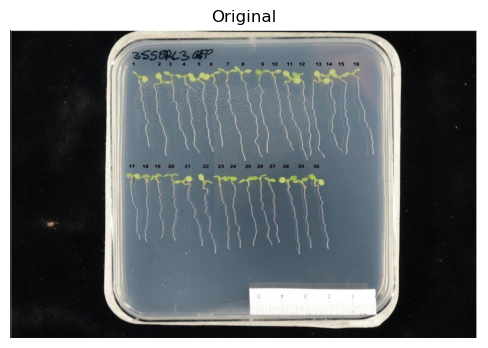

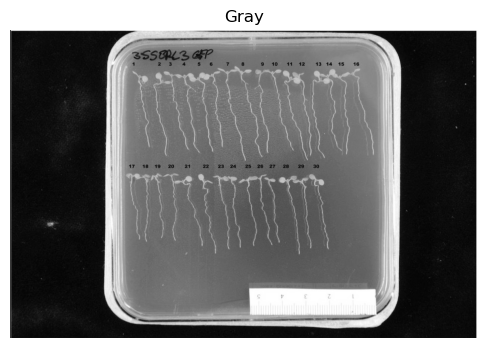

(716, 1088, 3)


In [85]:
IMAGE_PATH = "Test1.jpeg"   # <-- your file
img = cv2.imread(IMAGE_PATH, cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

show(img, "Original")
show(gray, "Gray", cmap="gray")
print(img.shape)


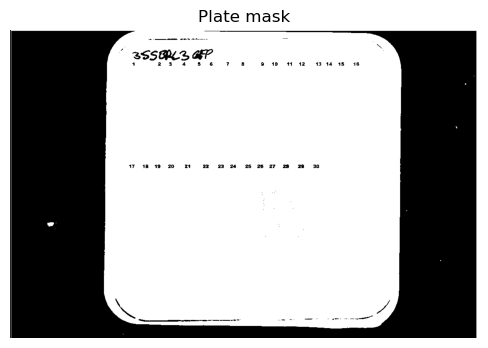

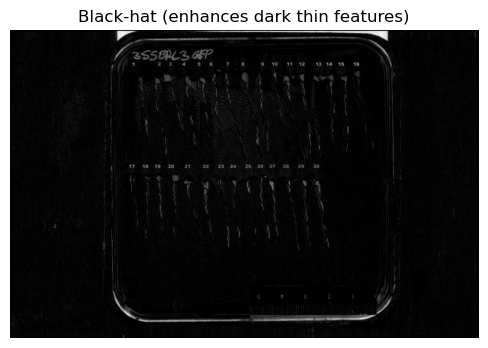

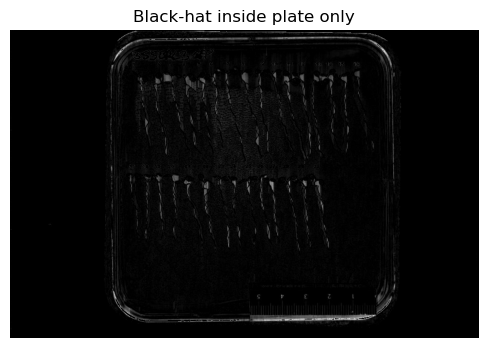

In [86]:
# --- plate mask (simple Otsu) to avoid background dominating projections ---
_, plate_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# --- enhance “dark thin structures” (ticks, digits, edges) using black-hat ---
g = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
k_bh = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 25))  #kernel
blackhat = cv2.morphologyEx(g, cv2.MORPH_BLACKHAT, k_bh)

# Keep only inside plate
bh_plate = blackhat * (plate_mask > 0)

show(plate_mask, "Plate mask", cmap="gray")
show(blackhat, "Black-hat (enhances dark thin features)", cmap="gray")
show(bh_plate, "Black-hat inside plate only", cmap="gray")


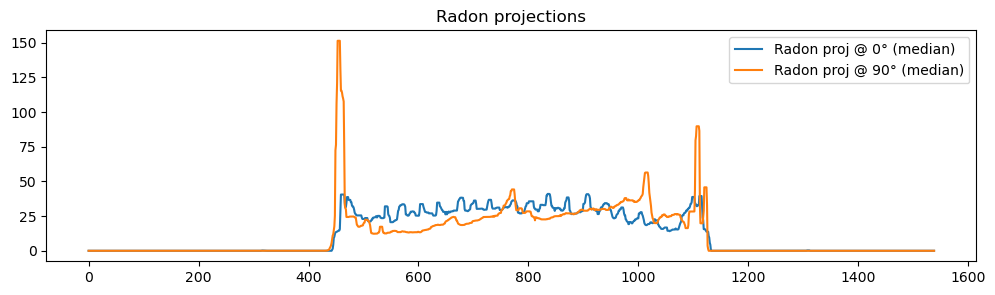

In [87]:
I = normalize01(bh_plate)

R = radon(I, theta=[0, 90], circle=False)  # shape: (rho, 2)
proj0 = median_filter(R[:, 0], size=9)     # theta=0
proj90 = median_filter(R[:, 1], size=9)    # theta=90

plt.figure(figsize=(12,3))
plt.plot(proj0, label="Radon proj @ 0° (median)")
plt.plot(proj90, label="Radon proj @ 90° (median)")
plt.legend(); plt.title("Radon projections"); plt.show()


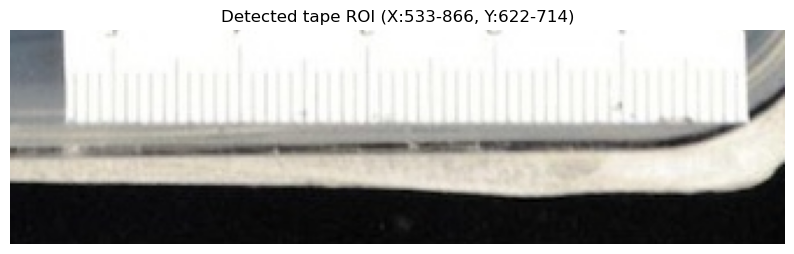

In [88]:
# --- Find Y band (tape is near bottom). Use smoothed row-sum of bh_plate ---
row_strength = bh_plate.sum(axis=1).astype(np.float32)
row_strength_s = cv2.GaussianBlur(row_strength.reshape(-1,1), (1,81), 0).ravel()

# pick strongest band in lower half
lower = row_strength_s[len(row_strength_s)//2:]
y_peak = np.argmax(lower) + len(row_strength_s)//2

thr_y = np.percentile(row_strength_s, 92)
y_mask = row_strength_s > thr_y

y0 = y_peak
while y0 > 0 and y_mask[y0]: y0 -= 1
y1 = y_peak
while y1 < len(y_mask)-1 and y_mask[y1]: y1 += 1

# --- Find X band inside that Y band ---
band = bh_plate[y0:y1, :]
col_strength = band.sum(axis=0).astype(np.float32)
col_strength_s = cv2.GaussianBlur(col_strength.reshape(1,-1), (81,1), 0).ravel()

# focus on right half (tape is right-ish in this photo)
right = col_strength_s[len(col_strength_s)//2:]
x_peak = np.argmax(right) + len(col_strength_s)//2

thr_x = np.percentile(col_strength_s, 75)
x_mask = col_strength_s > thr_x

x0 = x_peak
while x0 > 0 and x_mask[x0]: x0 -= 1
x1 = x_peak
while x1 < len(x_mask)-1 and x_mask[x1]: x1 += 1

# pad
pad_y, pad_x = 30, 30
Y0 = max(0, y0 - pad_y); Y1 = min(img.shape[0], y1 + pad_y)
X0 = max(0, x0 - pad_x); X1 = min(img.shape[1], x1 + pad_x)

tape_roi = img[Y0:Y1, X0:X1]
tape_gray = cv2.cvtColor(tape_roi, cv2.COLOR_BGR2GRAY)

show(tape_roi, f"Detected tape ROI (X:{X0}-{X1}, Y:{Y0}-{Y1})", figsize=(10,3))


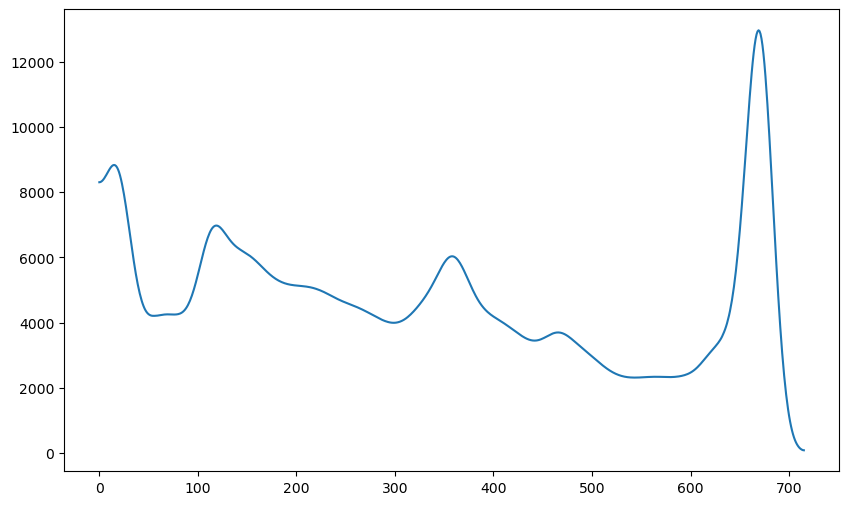

In [89]:
plt.plot(row_strength_s)

In [90]:
y1

np.int64(684)

In [91]:
y0

np.int64(652)

Estimated rotation correction (deg): -0.5


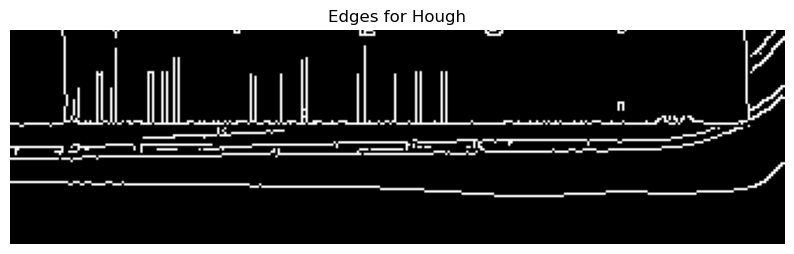

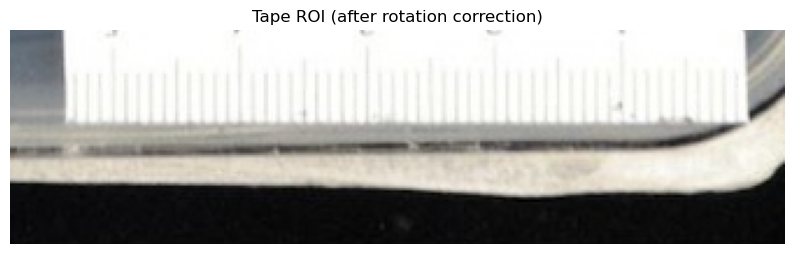

In [55]:
edges = cv2.Canny(tape_gray, 50, 150)
lines = cv2.HoughLines(edges, 1, np.pi/180, 120)

rot_deg = 0.0
if lines is not None:
    thetas = np.rad2deg(lines[:,0,1])
    # OpenCV theta is the angle of the NORMAL, so horizontal lines give ~90°
    theta_med = float(np.median(thetas))
    # If theta is not ~90, rotate to make it ~90
    rot_deg = (theta_med - 90.0)
print("Estimated rotation correction (deg):", rot_deg)

# rotate if needed
if abs(rot_deg) > 0.5:
    h,w = tape_roi.shape[:2]
    M = cv2.getRotationMatrix2D((w/2,h/2), rot_deg, 1.0)
    tape_roi = cv2.warpAffine(tape_roi, M, (w,h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    tape_gray = cv2.cvtColor(tape_roi, cv2.COLOR_BGR2GRAY)

show(edges, "Edges for Hough", cmap="gray", figsize=(10,3))
show(tape_roi, "Tape ROI (after rotation correction)", figsize=(10,3))


In [56]:
lines

array([[[40.       ,  1.5707964]],

       [[55.       ,  1.553343 ]],

       [[51.       ,  1.553343 ]],

       [[65.       ,  1.5882496]]], dtype=float32)

In [93]:
thetas = np.rad2deg(lines[:,0,1])  # get all theta values
theta_med = float(np.median(thetas))
rot_deg = (theta_med - 90.0)

theta_med

89.5

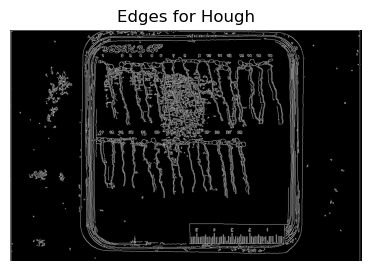

In [94]:
show(edges, "Edges for Hough", cmap="gray", figsize=(10,3))

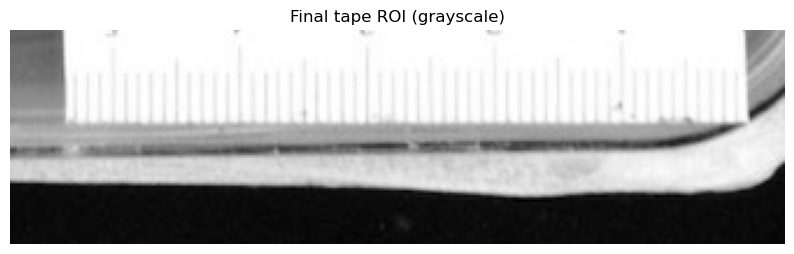

In [95]:
show(tape_gray, "Final tape ROI (grayscale)", cmap="gray", figsize=(10,3))

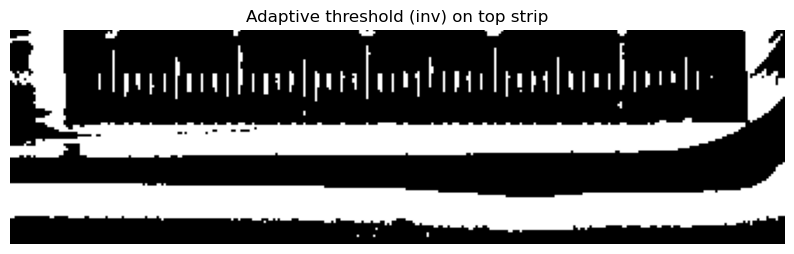

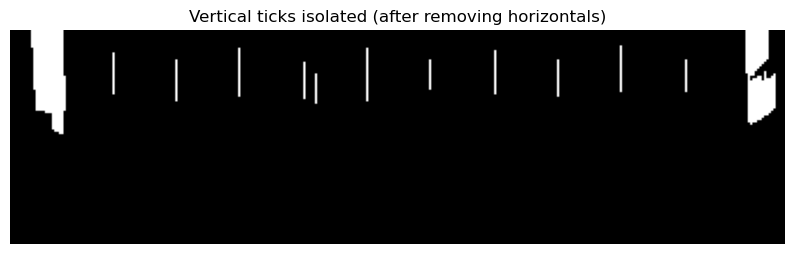

Detected tick peaks: 12


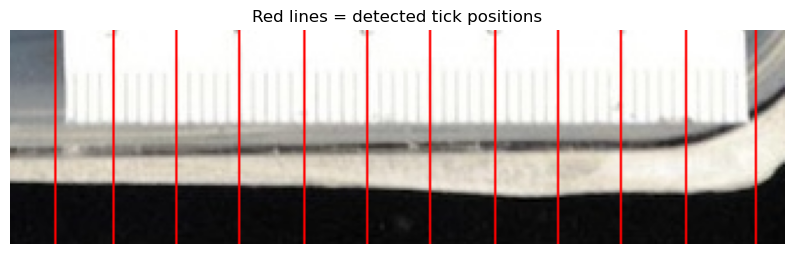

Median spacing between detected ticks (pixels): 27.0


In [57]:
# take a top strip where ticks are visible
strip = tape_gray[0:140, :]

# adaptive threshold -> ticks become white (binary inverse)
ad = cv2.adaptiveThreshold(strip, 255,
                          cv2.ADAPTIVE_THRESH_MEAN_C,
                          cv2.THRESH_BINARY_INV,
                          31, 7)

# remove horizontal structures (tape border / bar) by extracting horizontals
hk = cv2.getStructuringElement(cv2.MORPH_RECT, (35, 3))
horiz = cv2.morphologyEx(ad, cv2.MORPH_OPEN, hk)
ad2 = cv2.subtract(ad, horiz)

# keep vertical lines (ticks) with vertical opening
vk = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 12))
vert = cv2.morphologyEx(ad2, cv2.MORPH_OPEN, vk)

show(ad, "Adaptive threshold (inv) on top strip", cmap="gray", figsize=(10,3))
show(vert, "Vertical ticks isolated (after removing horizontals)", cmap="gray", figsize=(10,3))

# x-profile: how much vertical-tick ink per column
xprof = vert.sum(axis=0).astype(np.float32)
xprof_s = cv2.GaussianBlur(xprof.reshape(1,-1), (9,1), 0).ravel()

# peak find (tick x positions)
peaks, props = find_peaks(xprof_s, distance=12, prominence=np.max(xprof_s)*0.05)
print("Detected tick peaks:", len(peaks))

# visualize peaks
vis = tape_roi.copy()
for x in peaks:
    cv2.line(vis, (int(x), 0), (int(x), vis.shape[0]-1), (0,0,255), 1)
show(vis, "Red lines = detected tick positions", figsize=(10,3))

# spacing in pixels
diffs = np.diff(peaks)
diffs = diffs[(diffs > 3) & (diffs < 200)]
px_per_step = float(np.median(diffs))
print("Median spacing between detected ticks (pixels):", px_per_step)


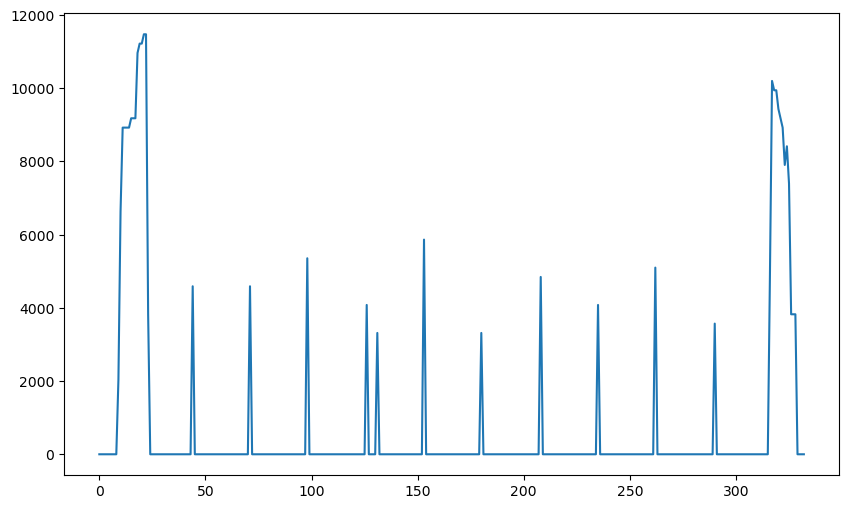

In [58]:
plt.plot(xprof)

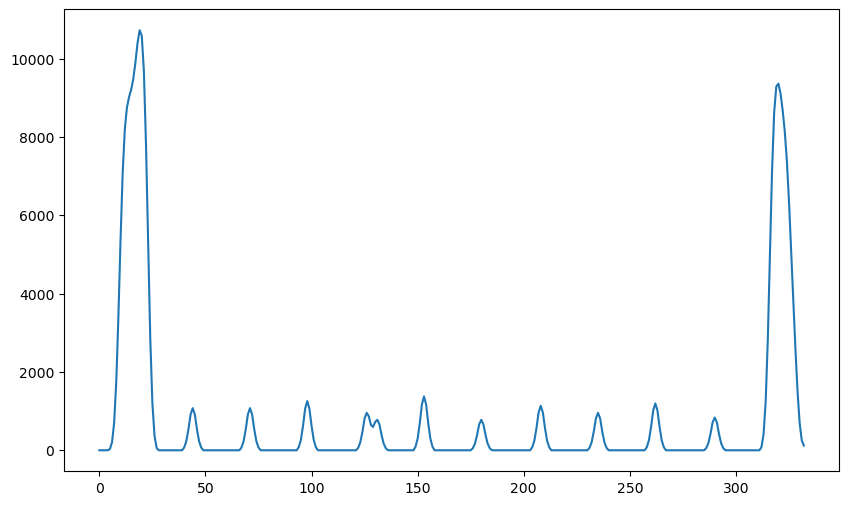

In [59]:
plt.plot(xprof_s)

In [60]:
peaks 

array([ 19,  44,  71,  98, 126, 153, 180, 208, 235, 262, 290, 320])

In [61]:
diffs

array([25, 27, 27, 28, 27, 27, 28, 27, 27, 28, 30])

In [62]:
px_per_step

27.0

In [63]:
px = px_per_step

# Hypotheses:
# - peaks are every 1 mm  -> mm_per_px = 1 / px
# - peaks are every 5 mm  -> mm_per_px = 5 / px
# - peaks are every 10 mm -> mm_per_px = 10 / px

mm_per_px_1  = 1.0  / px
mm_per_px_5  = 5.0  / px
mm_per_px_10 = 10.0 / px

print("If detected ticks are 1mm apart : mm/px =", mm_per_px_1)
print("If detected ticks are 5mm apart : mm/px =", mm_per_px_5)
print("If detected ticks are 10mm apart: mm/px =", mm_per_px_10)


If detected ticks are 1mm apart : mm/px = 0.037037037037037035
If detected ticks are 5mm apart : mm/px = 0.18518518518518517
If detected ticks are 10mm apart: mm/px = 0.37037037037037035


## 2. Root segmentation and detection

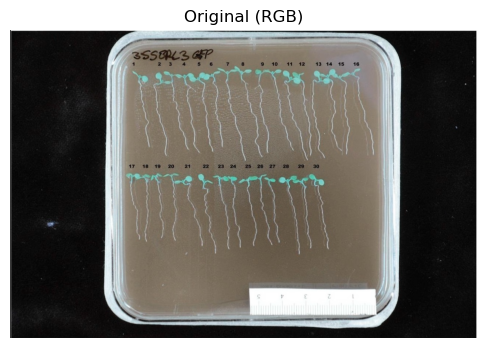

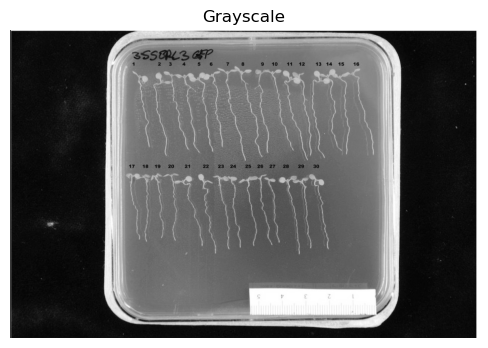

Shape: (716, 1088, 3)


In [99]:
# =========================
# Cell 1 — Load the image
# =========================

IMAGE_PATH = "Test1.jpeg"

img_bgr = cv2.imread(IMAGE_PATH, cv2.IMREAD_COLOR)
assert img_bgr is not None, f"Could not read image: {IMAGE_PATH}"

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

show(img_rgb, "Original (RGB)")
show(gray, "Grayscale", cmap="gray")
print("Shape:", img_bgr.shape)


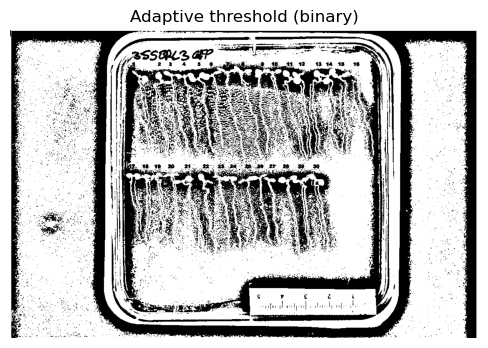

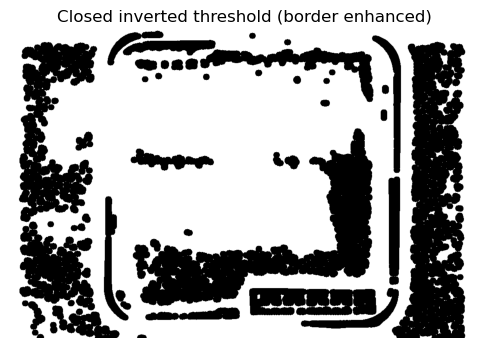

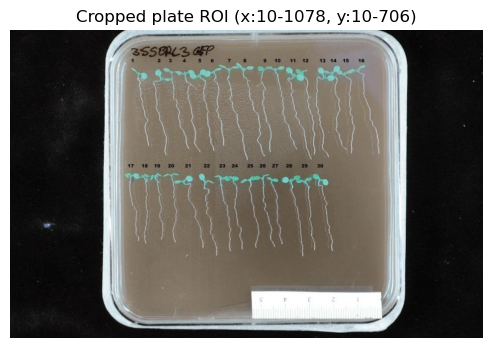

Plate ROI shape: (696, 1068, 3)


In [101]:
# ============================================================
# Cell 2 — Plate Cropping (Adaptive threshold -> border -> ROI)
# ============================================================

# Adaptive threshold to detect border-ish structures on the plate
blockSize = 81  # must be odd; tune if needed
C = 6

adapt = cv2.adaptiveThreshold(gray, 255,
                              cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                              cv2.THRESH_BINARY,
                              blockSize, C)

# Invert so plate border tends to be white (depends on lighting)
adapt_inv = 255 - adapt

# Clean up: close gaps in border
k_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
closed = cv2.morphologyEx(adapt_inv, cv2.MORPH_CLOSE, k_close)

# Find largest contour (plate region)
contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
assert len(contours) > 0, "No contours found for plate cropping. Try adjusting blockSize/C."

cnt = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(cnt)

# Slight inward padding to avoid plastic edges
pad = 10
x0 = max(0, x + pad)
y0 = max(0, y + pad)
x1 = min(img_rgb.shape[1], x + w - pad)
y1 = min(img_rgb.shape[0], y + h - pad)

plate_rgb = img_rgb[y0:y1, x0:x1].copy()
plate_gray = gray[y0:y1, x0:x1].copy()

show(adapt, "Adaptive threshold (binary)", cmap="gray")
show(closed, "Closed inverted threshold (border enhanced)", cmap="gray")
show(plate_rgb, f"Cropped plate ROI (x:{x0}-{x1}, y:{y0}-{y1})")
print("Plate ROI shape:", plate_rgb.shape)


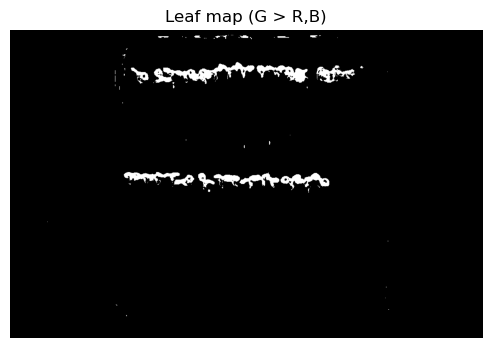

In [112]:
# =========================================================
# Cell 3 — Green Leaf Detection (G > R and G > B)
# =========================================================

R = plate_rgb[:, :, 0].astype(np.int16)
G = plate_rgb[:, :, 1].astype(np.int16)
B = plate_rgb[:, :, 2].astype(np.int16)

# Leaf map: green channel higher than red and blue by a margin
margin = 4  # tune
leaf_map = ((G > R + margin) & (G > B + margin)).astype(np.uint8) * 255

show(leaf_map, "Leaf map (G > R,B)", cmap="gray")


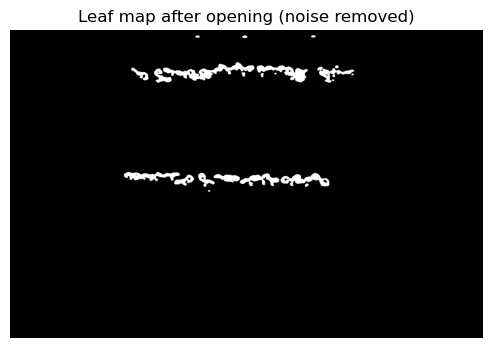

In [113]:
# =========================================================
# Cell 4 — Noise Removal (Morphological opening on leaf map)
# =========================================================

k_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
leaf_clean = cv2.morphologyEx(leaf_map, cv2.MORPH_OPEN, k_open)

show(leaf_clean, "Leaf map after opening (noise removed)", cmap="gray")


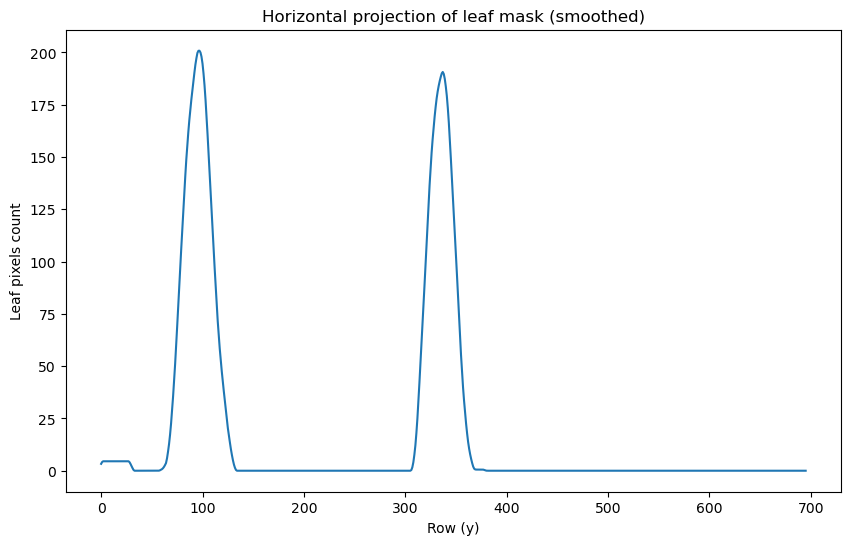

Detected row peaks (y indices): [97, 337]


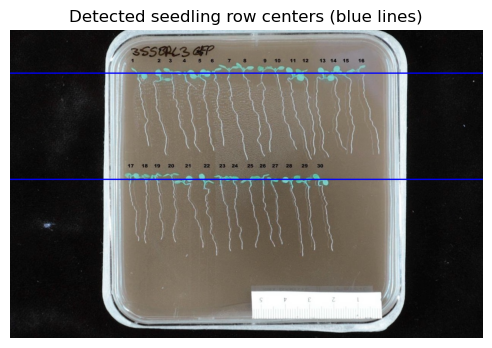

In [116]:
# =====================================================================================
# Cell 5 — Seedling Row Detection (Horizontal projection -> peaks = row centerlines)
# =====================================================================================

leaf_bin = (leaf_clean > 0).astype(np.uint8)

# Horizontal projection: sum across columns (per row)
proj_y = leaf_bin.sum(axis=1).astype(np.float32)

# Smooth projection (simple moving average via convolution)
win = 31
kernel = np.ones(win, dtype=np.float32) / win
proj_y_s = np.convolve(proj_y, kernel, mode="same")

plt.figure()
plt.title("Horizontal projection of leaf mask (smoothed)")
plt.plot(proj_y_s)
plt.xlabel("Row (y)")
plt.ylabel("Leaf pixels count")
plt.show()

# Find peaks (rows of seedlings)
# distance controls minimum separation between rows
peaks, props = find_peaks(proj_y_s, distance=plate_rgb.shape[0]//4, prominence=np.max(proj_y_s)*0.1)

print("Detected row peaks (y indices):", peaks.tolist())

# Visualize row lines
vis_rows = plate_rgb.copy()
for py in peaks:
    cv2.line(vis_rows, (0, int(py)), (vis_rows.shape[1]-1, int(py)), (255, 0, 0), 2)  # blue line in RGB
show(vis_rows, "Detected seedling row centers (blue lines)")


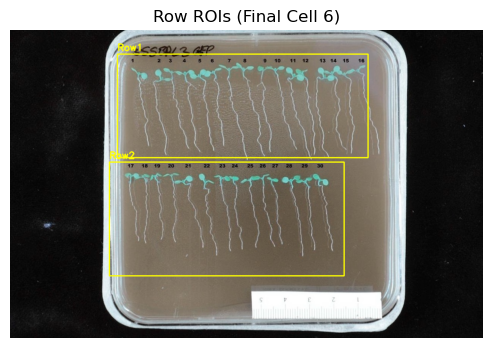

ROIs (top,bottom,left,right):
1 (54, 288, 242, 808)
2 (298, 555, 224, 754)


In [161]:
# =========================================================================================
# Cell 6 — Bounding Box Definition (FULL)
# Uses peaks from Cell 5 (row centerlines).
#
# Paper-faithful steps:
# 1) Top / Left / Right edges from LEAF binary image projections
#    - Horizontal projection of leaf band -> TOP (start of support)
#    - Vertical projection of leaf band   -> LEFT/RIGHT (support until ~0)
#    - Uses smoothed projections proj_x_s / proj_y_s in the calculus (as requested)
#
# 2) Bottom edge (Root tip limit) from LONGEST ROOTS in each ROI
#    - Otsu on ROI (from top to bottom of plate)
#    - Morphological opening to remove isolated noise (scratches/droplets)
#    - Remove non-vertical connected components (keep tall+thin)
#    - Horizontal projection -> uniform quantization
#    - Bottom = first zero-run after largest peak
#
# 3) Multi-row constraint (important!)
#    - If multiple rows detected, clamp Row i bottom so it cannot overlap Row i+1:
#      bottom_i <= top_{i+1} - margin
#
# Requires from previous cells:
# - leaf_bin (from Cell 5)
# - peaks   (from Cell 5)
# - plate_gray, plate_rgb
# - show() helper
# =========================================================================================

import cv2
import numpy as np

# -----------------------------
# Helpers
# -----------------------------
def smooth_1d(x, win=31):
    win = int(win)
    if win < 3:
        return x.astype(np.float32)
    if win % 2 == 0:
        win += 1
    k = np.ones(win, dtype=np.float32) / win
    return np.convolve(x.astype(np.float32), k, mode="same")

def uniform_quantize_1d(x, levels=10):
    x = x.astype(np.float32)
    mn, mx = x.min(), x.max()
    if mx - mn < 1e-6:
        return np.zeros_like(x, dtype=np.int32)
    return np.floor((x - mn) / (mx - mn + 1e-8) * (levels - 1)).astype(np.int32)

def support_edges_1d(sig, eps_ratio=0.02):
    """
    Support edges until it returns to ~0.
    eps = eps_ratio * max(sig).
    Returns (start,end) in index space of sig.
    """
    sig = sig.astype(np.float32)
    mx = sig.max()
    if mx <= 1e-6:
        return 0, len(sig) - 1
    eps = eps_ratio * mx
    idx = np.where(sig > eps)[0]
    if len(idx) == 0:
        return 0, len(sig) - 1
    return int(idx[0]), int(idx[-1])

def first_zero_run_after_peak(q, zero_run=12):
    peak = int(np.argmax(q))
    z = 0
    for i in range(peak + 1, len(q)):
        if q[i] == 0:
            z += 1
            if z >= zero_run:
                return i - zero_run + 1
        else:
            z = 0
    return len(q) - 1

# -----------------------------
# Leaf edges from projections (uses proj_x_s explicitly)
# -----------------------------
def leaf_edges_from_projections(leaf_bin, py,
                                band_half_height=70,
                                proj_x_win=41,
                                proj_y_win=21,
                                eps_ratio_x=0.02,
                                eps_ratio_y=0.02,
                                top_pad=15,
                                side_pad=15):
    """
    Compute top/left/right from leaf projections in a band around row centerline py.
    - proj_x_s used to find left/right support until ~0
    - proj_y_s used to find top as start of support
    """
    H, W = leaf_bin.shape
    y0 = max(0, int(py - band_half_height))
    y1 = min(H, int(py + band_half_height))
    band = leaf_bin[y0:y1, :]

    proj_x = band.sum(axis=0).astype(np.float32)  # vertical projection
    proj_y = band.sum(axis=1).astype(np.float32)  # horizontal projection (within band)

    proj_x_s = smooth_1d(proj_x, win=proj_x_win)
    proj_y_s = smooth_1d(proj_y, win=proj_y_win)

    left0, right0 = support_edges_1d(proj_x_s, eps_ratio=eps_ratio_x)
    top0, _ = support_edges_1d(proj_y_s, eps_ratio=eps_ratio_y)

    left = max(0, left0 - side_pad)
    right = min(W - 1, right0 + side_pad)
    top = max(0, (y0 + top0) - top_pad)

    return top, left, right, (y0, y1), proj_x_s, proj_y_s

# -----------------------------
# Bottom edge from longest roots (Fig.5(b))
# -----------------------------
def bottom_edge_from_longest_roots(plate_gray, top, left, right,
                                  otsu_invert=True,
                                  scratch_open_kernel=(3,3),
                                  vert_kernel_len=25,
                                  cc_min_h=35,
                                  cc_max_w=18,
                                  cc_min_ar=3.5,
                                  quant_levels=10,
                                  zero_run=12,
                                  max_col_coverage_frac=0.20):
    """
    Otsu -> opening -> remove non-vertical CCs -> horizontal projection -> quantize
    -> first zero-run after largest peak.
    Returns bottom (plate coords) + intermediate signals.
    """
    roi = plate_gray[top:, left:right]
    Hroi, Wroi = roi.shape

    # Otsu polarity
    if otsu_invert:
        _, bw = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    else:
        _, bw = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 1) opening (paper: remove isolated noise from scratches/droplets)
    k_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, scratch_open_kernel)
    bw2 = cv2.morphologyEx(bw, cv2.MORPH_OPEN, k_open)

    # 2) keep vertical strokes
    vk = cv2.getStructuringElement(cv2.MORPH_RECT, (1, vert_kernel_len))
    vertical = cv2.morphologyEx(bw2, cv2.MORPH_OPEN, vk)

    # 3) CC filtering: keep tall+thin, reject dense horizontal coverage (ruler-like)
    num, labels, stats, _ = cv2.connectedComponentsWithStats(vertical, 8)
    roots_only = np.zeros_like(vertical)

    for lab in range(1, num):
        x, y, w, h, area = stats[lab]
        if h < cc_min_h:
            continue
        if w <= 0 or w > cc_max_w:
            continue
        if (h / float(w)) < cc_min_ar:
            continue

        mask = (labels == lab)

        cols_covered = np.unique(np.where(mask)[1]).size
        if cols_covered > max_col_coverage_frac * Wroi:
            continue

        roots_only[mask] = 255

    # projection -> quantization -> decision
    proj = (roots_only > 0).sum(axis=1).astype(np.float32)
    proj_s = smooth_1d(proj, win=31)
    q = uniform_quantize_1d(proj_s, levels=quant_levels)

    tip_rel = first_zero_run_after_peak(q, zero_run=zero_run)
    bottom = min(plate_gray.shape[0] - 1, top + tip_rel)

    return bottom, roots_only, proj_s, q

# =========================================================================================
# MAIN: Compute ROIs for all rows
# =========================================================================================

# ------------- Parameters you may tune -------------
BAND_HALF_HEIGHT = 70
LEAF_EPS_X = 0.02
LEAF_EPS_Y = 0.02
TOP_PAD = 15
SIDE_PAD = 15

OTSU_INVERT = True          # if root projection becomes flat zero, try False
ZERO_RUN = 12               # stability for "first zero"
CLAMP_MARGIN = 10           # enforce separation between rows

# root CC filters
CC_MIN_H = 35
CC_MAX_W = 18
CC_MIN_AR = 3.5
MAX_COL_COVER = 0.20        # tighten to 0.15/0.12 if ruler still leaks

# ---------------------------------------------------

rois = []
row_debug_cache = []

for py in peaks:
    # Top/Left/Right from leaf projections
    top, left, right, band, proj_x_s, proj_y_s = leaf_edges_from_projections(
        leaf_bin, py,
        band_half_height=BAND_HALF_HEIGHT,
        eps_ratio_x=LEAF_EPS_X,
        eps_ratio_y=LEAF_EPS_Y,
        top_pad=TOP_PAD,
        side_pad=SIDE_PAD
    )

    # Bottom from longest roots
    bottom, roots_only, proj_root_y, q_root_y = bottom_edge_from_longest_roots(
        plate_gray, top, left, right,
        otsu_invert=OTSU_INVERT,
        scratch_open_kernel=(3,3),
        vert_kernel_len=25,
        cc_min_h=CC_MIN_H,
        cc_max_w=CC_MAX_W,
        cc_min_ar=CC_MIN_AR,
        quant_levels=10,
        zero_run=ZERO_RUN,
        max_col_coverage_frac=MAX_COL_COVER
    )

    rois.append((top, bottom, left, right))
    row_debug_cache.append({
        "py": int(py),
        "band": band,
        "top": top, "bottom": bottom, "left": left, "right": right,
        "proj_x_s": proj_x_s,     # included explicitly
        "proj_y_s": proj_y_s,
        "roots_only": roots_only,
        "proj_root_y": proj_root_y,
        "q_root_y": q_root_y
    })

# =========================================================================================
# Enforce non-overlap between rows: bottom_i <= top_{i+1} - margin
# =========================================================================================
if len(rois) >= 2:
    order = np.argsort([d["py"] for d in row_debug_cache])  # top-to-bottom
    rois_sorted = [rois[i] for i in order]
    tops_sorted = [rois_sorted[i][0] for i in range(len(rois_sorted))]

    rois_clamped = []
    for i, (t, b, l, r) in enumerate(rois_sorted):
        if i < len(rois_sorted) - 1:
            next_top = tops_sorted[i + 1]
            b = min(b, max(t, next_top - CLAMP_MARGIN))
        rois_clamped.append((t, b, l, r))

    # map back
    for k, idx in enumerate(order):
        rois[idx] = rois_clamped[k]
        row_debug_cache[idx]["bottom"] = rois_clamped[k][1]

# =========================================================================================
# Visualize final ROIs
# =========================================================================================
vis = plate_rgb.copy()
for i, (t, b, l, r) in enumerate(rois, 1):
    cv2.rectangle(vis, (l, t), (r, b), (0, 255, 255), 2)  # cyan
    cv2.putText(vis, f"Row{i}", (l, max(0, t-8)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,255), 2)

show(vis, "Row ROIs (Final Cell 6)")

print("ROIs (top,bottom,left,right):")
for i, roi in enumerate(rois, 1):
    print(i, roi)


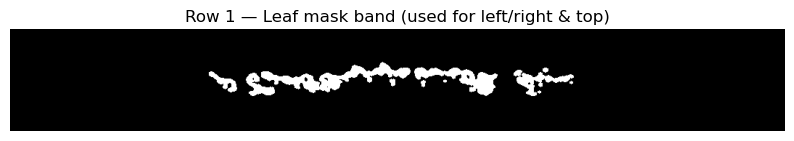

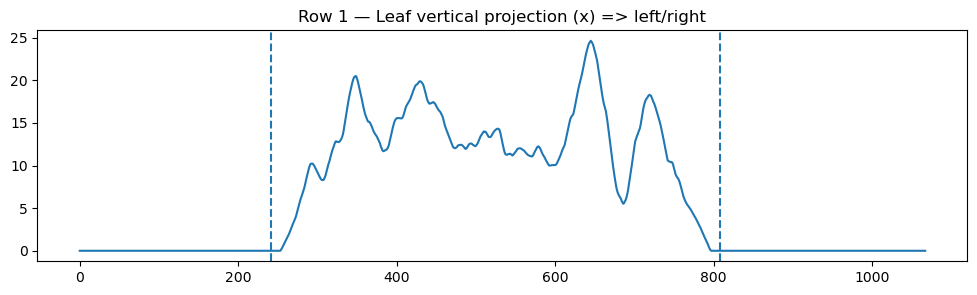

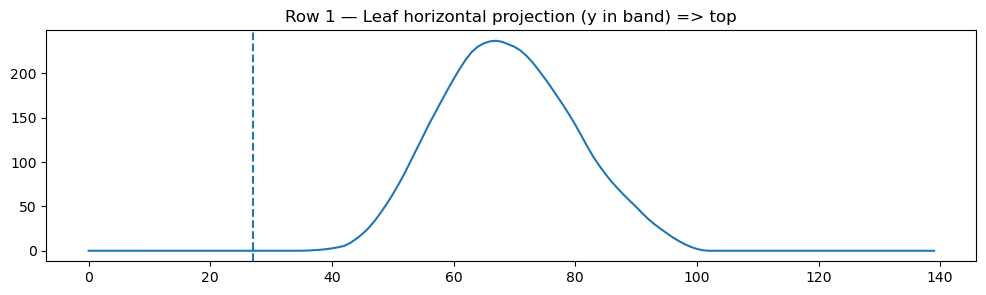

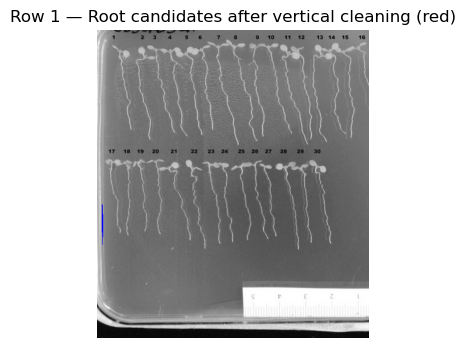

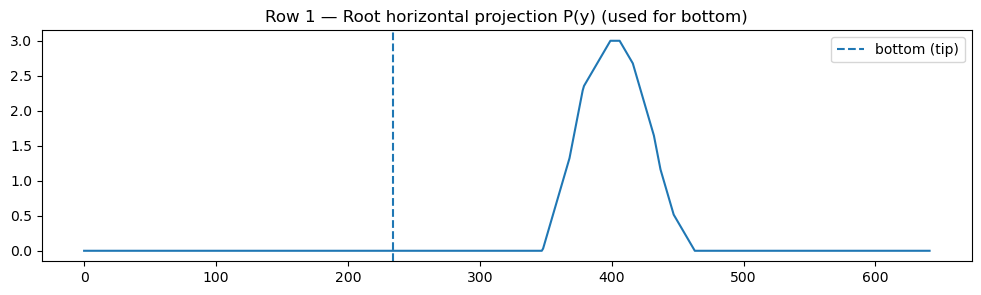

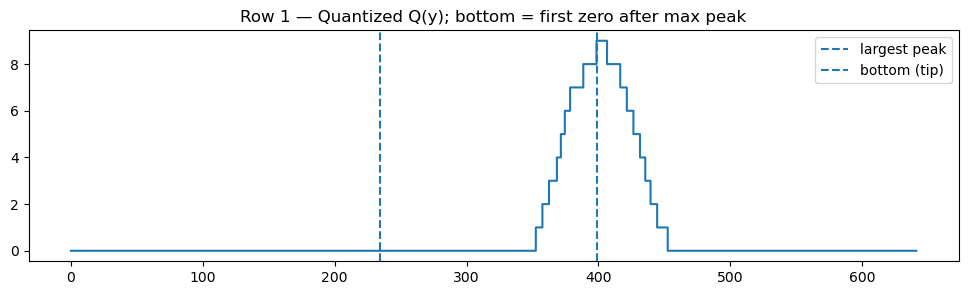

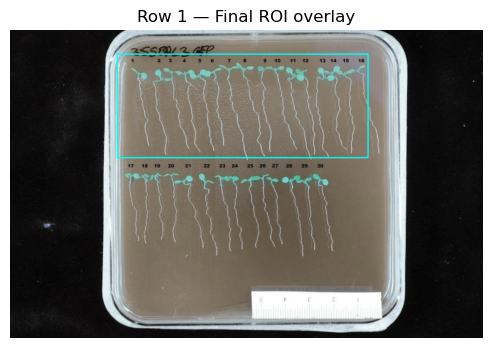

In [162]:
# =========================================================================================
# Debug Block — Intermediate steps for ONE row (Fig.5-style)
# =========================================================================================

row_idx = 1  # change to 1 or 2

d = row_debug_cache[row_idx - 1]
t, b, l, r = d["top"], d["bottom"], d["left"], d["right"]
y0_band, y1_band = d["band"]

# 1) Leaf band view (Fig.5a)
band_leaf = (leaf_bin[y0_band:y1_band, :] * 255).astype(np.uint8)
show(band_leaf, f"Row {row_idx} — Leaf mask band (used for left/right & top)", cmap="gray")

# 2) Leaf projections (why left/right and top)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,3))
plt.title(f"Row {row_idx} — Leaf vertical projection (x) => left/right")
plt.plot(d["proj_x_s"])
plt.axvline(l, linestyle="--"); plt.axvline(r, linestyle="--")
plt.show()

plt.figure(figsize=(12,3))
plt.title(f"Row {row_idx} — Leaf horizontal projection (y in band) => top")
plt.plot(d["proj_y_s"])
plt.axvline(t - y0_band, linestyle="--")
plt.show()

# 3) Longest roots candidates (Fig.5b top) inside ROI-from-top
roi_gray = plate_gray[t:, l:r]
roots_only = d["roots_only"]
overlay = cv2.cvtColor(roi_gray, cv2.COLOR_GRAY2RGB)
overlay[roots_only > 0] = [255, 0, 0]
show(overlay, f"Row {row_idx} — Root candidates after vertical cleaning (red)")

# 4) Root projection + quantized (Fig.5b middle/bottom)
plt.figure(figsize=(12,3))
plt.title(f"Row {row_idx} — Root horizontal projection P(y) (used for bottom)")
plt.plot(d["proj_root_y"])
plt.axvline(b - t, linestyle="--", label="bottom (tip)")
plt.legend()
plt.show()

plt.figure(figsize=(12,3))
plt.title(f"Row {row_idx} — Quantized Q(y); bottom = first zero after max peak")
plt.plot(d["q_root_y"], drawstyle="steps-mid")
plt.axvline(np.argmax(d["q_root_y"]), linestyle="--", label="largest peak")
plt.axvline(b - t, linestyle="--", label="bottom (tip)")
plt.legend()
plt.show()

# 5) Final ROI overlay (Fig.5c-style)
vis1 = plate_rgb.copy()
cv2.rectangle(vis1, (l, t), (r, b), (255, 255, 0), 2)
show(vis1, f"Row {row_idx} — Final ROI overlay")


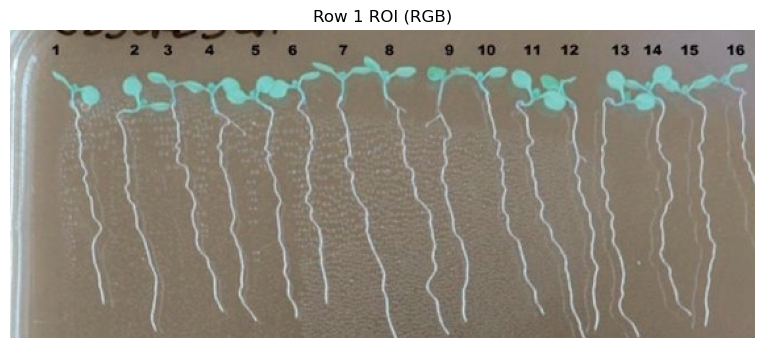

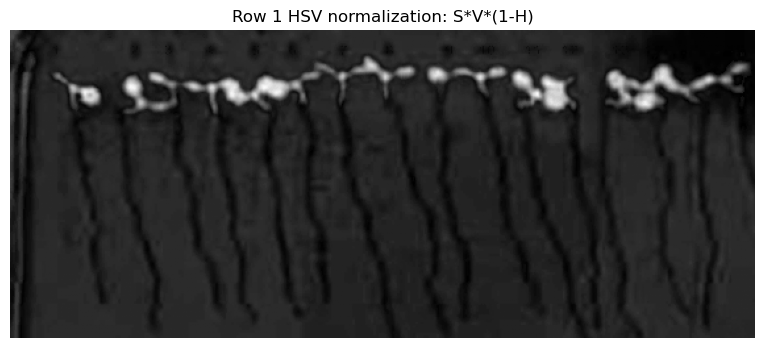

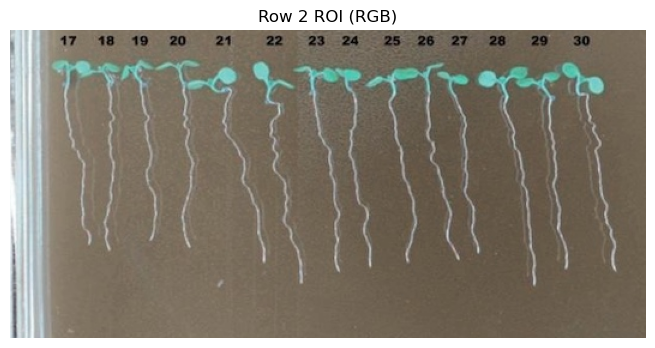

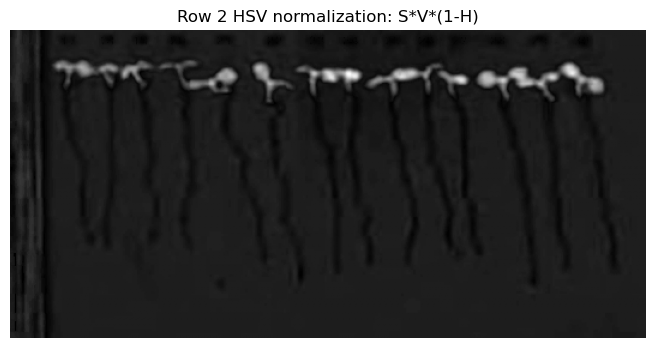

In [163]:
# =====================================================
# Cell 7 — Root Detection & Segmentation (per-row masks)
# Step 1: Color Normalization in HSV: S*V*(1-H)
# =====================================================

def hsv_root_contrast(roi_rgb):
    hsv = cv2.cvtColor(roi_rgb, cv2.COLOR_RGB2HSV).astype(np.float32)
    H = hsv[:, :, 0] / 179.0
    S = hsv[:, :, 1] / 255.0
    V = hsv[:, :, 2] / 255.0
    val = S * V * (1.0 - H)
    return normalize01(val)

# Show the contrast image for each row ROI
contrast_imgs = []
for i, (t, b, l, r) in enumerate(rois, 1):
    roi_rgb = plate_rgb[t:b, l:r]
    cimg = hsv_root_contrast(roi_rgb)
    contrast_imgs.append(cimg)
    show(roi_rgb, f"Row {i} ROI (RGB)")
    show(cimg, f"Row {i} HSV normalization: S*V*(1-H)", cmap="gray")


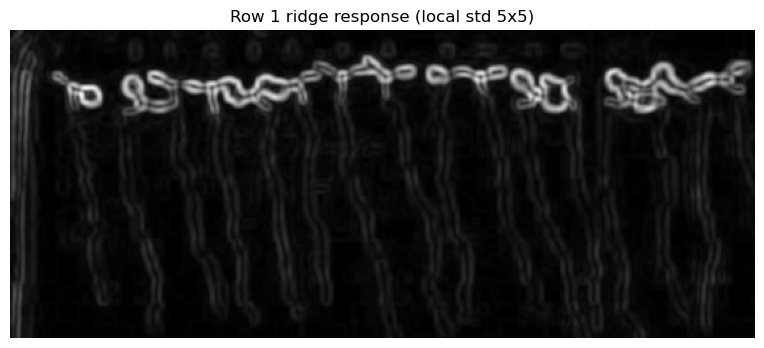

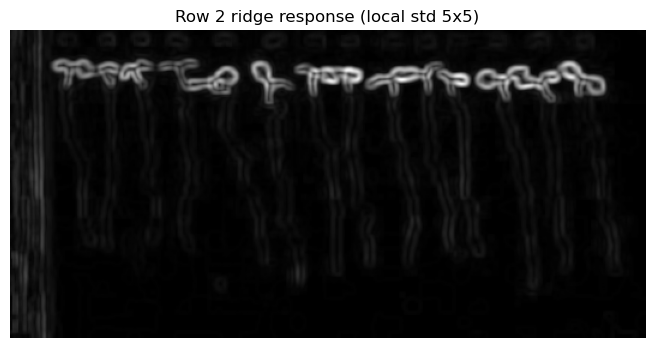

In [164]:
# =====================================================
# Cell 8 — Step 2: Ridge Detection (local std-dev 5x5)
# =====================================================

def local_std(img01, win=5):
    # std = sqrt(E[x^2] - (E[x])^2)
    mean = uniform_filter(img01, size=win)
    mean2 = uniform_filter(img01**2, size=win)
    var = np.maximum(mean2 - mean**2, 0)
    return np.sqrt(var)

ridge_imgs = []
for i, cimg in enumerate(contrast_imgs, 1):
    ridge = local_std(cimg, win=5)
    ridge01 = normalize01(ridge)
    ridge_imgs.append(ridge01)
    show(ridge01, f"Row {i} ridge response (local std 5x5)", cmap="gray")


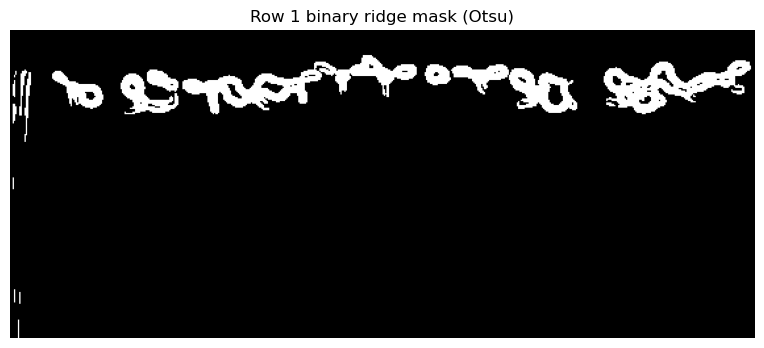

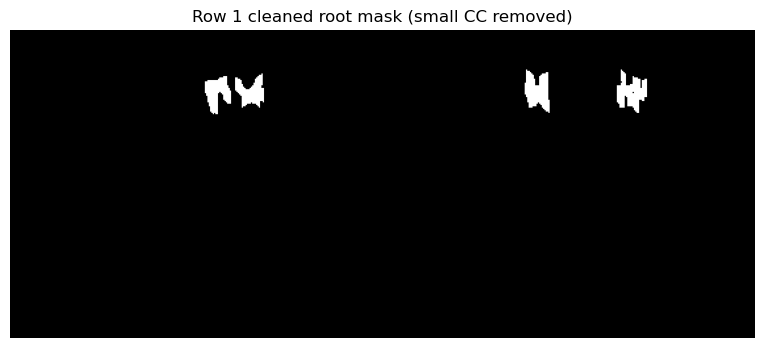

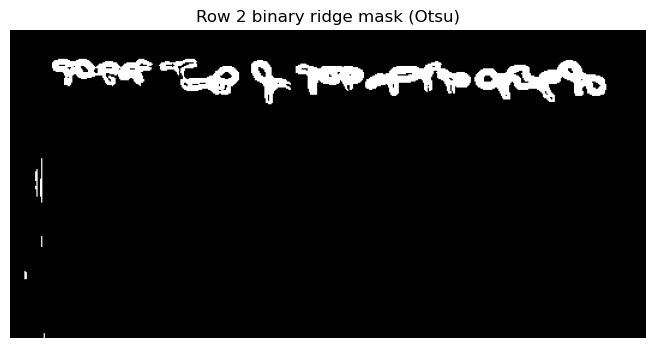

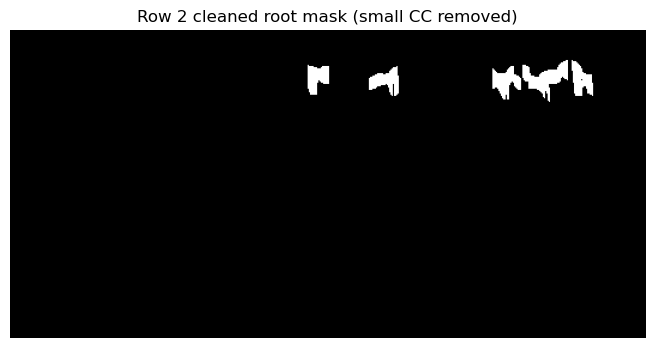

In [165]:
# =====================================================
# Cell 9 — Step 3: Binarization + Cleaning (remove small CCs)
# =====================================================

def otsu_threshold(img01):
    # Otsu on 8-bit
    u8 = (img01 * 255).astype(np.uint8)
    _, thr = cv2.threshold(u8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return (thr > 0).astype(np.uint8)

def remove_small_components(bin01, min_area=200):
    # bin01 is 0/1
    u8 = (bin01 * 255).astype(np.uint8)
    num, labels, stats, _ = cv2.connectedComponentsWithStats(u8, connectivity=8)
    out = np.zeros_like(bin01, dtype=np.uint8)
    for lab in range(1, num):
        area = stats[lab, cv2.CC_STAT_AREA]
        if area >= min_area:
            out[labels == lab] = 1
    return out

root_masks = []
for i, ridge01 in enumerate(ridge_imgs, 1):
    # binarize
    b = otsu_threshold(ridge01)

    # optional: emphasize elongated vertical-ish structures a bit
    vk = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 9))
    b2 = cv2.morphologyEx((b*255).astype(np.uint8), cv2.MORPH_OPEN, vk)
    b2 = (b2 > 0).astype(np.uint8)

    # remove small components
    cleaned = remove_small_components(b2, min_area=300)

    root_masks.append(cleaned)

    show((b*255).astype(np.uint8), f"Row {i} binary ridge mask (Otsu)", cmap="gray")
    show((cleaned*255).astype(np.uint8), f"Row {i} cleaned root mask (small CC removed)", cmap="gray")


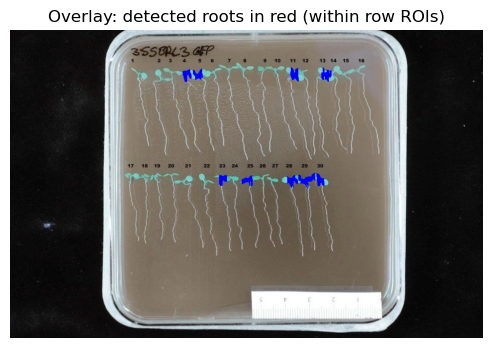

In [166]:
# =====================================================
# Cell 10 — Overlay masks back onto plate (sanity check)
# =====================================================

overlay = plate_rgb.copy()

for (t, b, l, r), mask in zip(rois, root_masks):
    roi = overlay[t:b, l:r]
    # color roots red on overlay
    roi[mask.astype(bool)] = [255, 0, 0]
    overlay[t:b, l:r] = roi

show(overlay, "Overlay: detected roots in red (within row ROIs)")


In [167]:
# =====================================================
# Cell 11 — Optional: Export per-row masks to disk
# =====================================================

out_dir = "myroot_outputs"
import os
os.makedirs(out_dir, exist_ok=True)

for i, ((t, b, l, r), mask) in enumerate(zip(rois, root_masks), 1):
    mask_u8 = (mask * 255).astype(np.uint8)
    cv2.imwrite(os.path.join(out_dir, f"row_{i:02d}_root_mask.png"), mask_u8)

print("Saved masks to:", out_dir)
print("Files:", sorted(os.listdir(out_dir))[:10], "...")


Saved masks to: myroot_outputs
Files: ['row_01_root_mask.png', 'row_02_root_mask.png'] ...
